In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [4]:
scintillator1_density = 4.57  # g/cm^3
material_file1 = './yagce.csv'

In [9]:
# Step 1: Read the linear attenuation data (X-ray energy in MeV, linear attenuation coefficient)
data = pd.read_csv(material_file1)
energy_mev = data.iloc[:, 0].values  # X-ray energy (MeV)
mu_over_rho = data.iloc[:, 1].values  # Linear attenuation coefficient (to be multiplied by density)

# Convert energy from MeV to keV for convenience
energy_keV = energy_mev * 1e3

Text(0, 0.5, 'Attenuation coefficient (cm-1)')

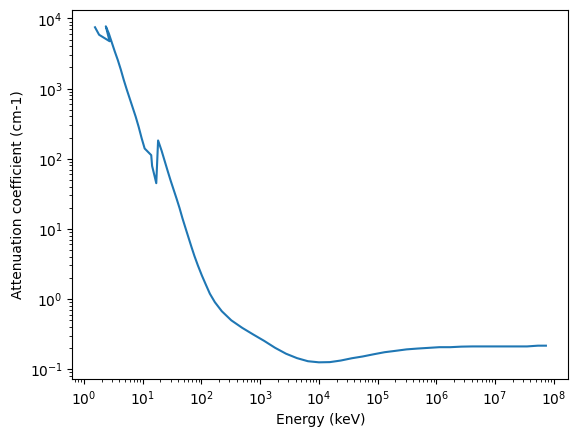

In [16]:
plt.figure()
plt.loglog(energy_keV, mu_over_rho*scintillator1_density)
plt.xlabel('Energy (keV)')
plt.ylabel('Attenuation coefficient (cm-1)')

In [27]:
# Step 2: Generate bremsstrahlung spectrum for a given X-ray tube potential (kVp)
def bremsstrahlung_spectrum(energy_keV, kVp):
    """ Generates the bremsstrahlung spectrum using Kramers' law approximation. """
    spectrum = np.zeros_like(energy_keV)
    for i, energy in enumerate(energy_keV):
        if energy <= kVp:
            spectrum[i] = (kVp - energy) * energy  # Kramers' law approximation
    # Normalize spectrum
    spectrum /= np.sum(spectrum)
    return spectrum

In [24]:
# Calculate effective depth of interaction (deprecated)
def effective_depth_of_interaction(energy_keV, mu_over_rho, spectrum, density):
    """ Calculate the effective depth of interaction using weighted attenuation coefficients. """
    mu = mu_over_rho * density  # Convert to linear attenuation (in cm^-1)
    
    # Calculate the weighted average of the attenuation depth (1/mu) across the spectrum
    effective_depth = np.sum(spectrum * (1 / mu)) / np.sum(spectrum)
    return effective_depth

In [149]:
# Step 3: Calculate average position of energy loss for given scintillator thickness
def average_energy_loss_position(energy_keV, mu_over_rho, spectrum, density, thickness):
    """ Calculate the average position of energy loss within a scintillator of given thickness. """
    
    def integrand_energy_deposited(x, mu):
        """ Returns the energy deposited at depth x. """
        return x * np.exp(-mu * density * x)
    
    def integrand_total_energy(x, mu):
        """ Returns the total energy intensity at depth x. """
        return np.exp(-mu * density * x)

    avg_positions = []

    # Loop over all energies in the spectrum
    for i, energy in enumerate(energy_keV):
        if spectrum[i] > 0:  # Only consider energies present in the spectrum
            mu = mu_over_rho[i] * density  # Linear attenuation coefficient for this energy
            
            # Calculate the average energy loss position for this energy component
            numerator = (thickness*mu + 1)*np.exp(-mu*thickness)-1
            denominator = (np.exp(-mu*thickness)-1)*mu
            
            avg_position = numerator / denominator
            avg_positions.append(avg_position * spectrum[i])  # Weight by spectrum intensity
    
    # Return the spectrum-weighted average depth
    return np.sum(avg_positions)

# Calculate the average position of energy loss for the bremsstrahlung spectrum
avg_energy_loss_depth = average_energy_loss_position(energy_keV, mu_over_rho, spectrum, scintillator1_density, scintillator_thickness)

# Output the result
print(f"Average Position of Energy Loss for 90 kVp X-rays: {avg_energy_loss_depth:.3f} cm")

Average Position of Energy Loss for 90 kVp X-rays: 0.000 cm


Average Position of Energy Loss for 90 kVp X-rays and thickness 0.5 mm : 0.1409892208298324 mm
Effective scintillator thickness = 0.35901077917016766


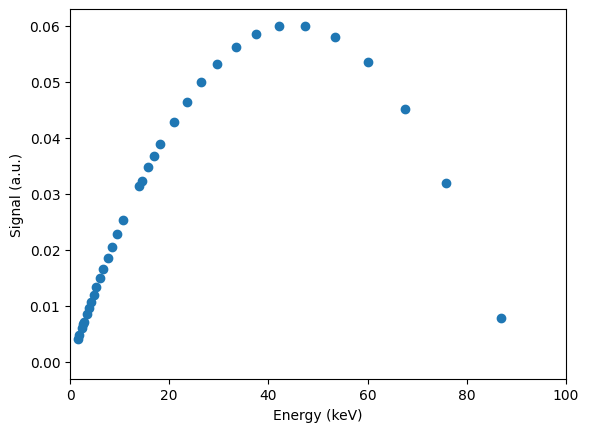

In [164]:
kVp = 90  # Example tube potential (90 keV)
spectrum = bremsstrahlung_spectrum(energy_keV, kVp)
plt.figure()
plt.plot(energy_keV, spectrum, 'o')
plt.xlim([0, kVp+10])
plt.xlabel('Energy (keV)')
plt.ylabel('Signal (a.u.)')

# Calculate the average position of energy loss for the bremsstrahlung spectrum
scintillator_thickness = 0.05 # in cm

# Calculate the average position of energy loss for the bremsstrahlung spectrum using discretization
avg_energy_loss_depth = average_energy_loss_position(energy_keV, mu_over_rho, spectrum, scintillator1_density, scintillator_thickness)

# Output the result
print("Average Position of Energy Loss for {0} kVp X-rays and thickness {1} mm : {2} mm".format(kVp, scintillator_thickness*10, avg_energy_loss_depth*10))
print("Effective scintillator thickness = {0}".format((scintillator_thickness-avg_energy_loss_depth)*10))